In [26]:
import torch
import emoji
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../')

from tqdm import tqdm
from config import GPT2EmojiConfig
from model import GPT2LMEmojiModel
from transformers import GPT2Tokenizer
from run_language_modeling import load_and_cache_examples, targets_mask
from sst_binary import sst_binary
from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


MODEL_CLASSES = {
    "gpt2": (GPT2EmojiConfig, GPT2LMEmojiModel, GPT2Tokenizer),
}

MODEL_PATH = '../checkpoint-180000'

args = torch.load(os.path.join(MODEL_PATH, 'training_args.bin'))

config_class, model_class, tokenizer_class = MODEL_CLASSES['gpt2']

config = config_class.from_pretrained(MODEL_PATH)

tokenizer = tokenizer_class.from_pretrained(MODEL_PATH)

model = model_class.from_pretrained(
            MODEL_PATH,
            config=config,
)

map_target_to_token_id = dict(
        zip(range(0, len(emoji.UNICODE_EMOJI.keys())), tokenizer.encode(list(emoji.UNICODE_EMOJI.keys())))
)

Token indices sequence length is longer than the specified maximum sequence length for this model (2811 > 1024). Running this sequence through the model will result in indexing errors


In [14]:
DATASETS = [
    'Olympic',
    'PsychExp',
    'SCv1',
    'SCv2-GEN',
    'SE0714',
    'SS-Twitter',
    'SS-Youtube',
]
DIR = '../data'
FILENAME_RAW = 'raw.pickle'
CLASSES = 'fear, joy, sadness'.split(', ')
TRAIN_SIZE = 250

In [4]:
def load_dataset(dataset):
    print(dataset)
    DATASET_PATH = f'{DIR}/{dataset}/{FILENAME_RAW}'
    with open(DATASET_PATH, 'rb') as file:
        data = pickle.load(file, fix_imports=True, encoding='bytes')
    
    # Decode data
    texts = [str(x) for x in data[b'texts']]
    # Extract labels
    labels = [x[b'label'] for x in data[b'info']]
    return texts, labels

def decode(y_in):
    y_out = []
    for y in y_in:
        y_out.append(np.argmax(y))
    return y_out

In [5]:
X, y = load_dataset(DATASETS[4])
y = decode(y)

SE0714


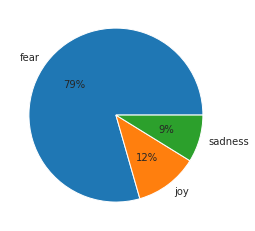

In [41]:
df = pd.DataFrame({'X': X, 'y': y})
ax = df.y.value_counts().plot.pie(labels=CLASSES, autopct='%1.0f%%')
ax.set_ylabel(None)
plt.savefig('SE0714-classes.pdf', dpi=300)

In [38]:
df.loc[df.y == 0]

,X,y
0,b'Mortar assault leaves at least 18 dead',0
2,b'Nigeria hostage feared dead is freed',0
3,b'Bombers kill shoppers',0
4,"b'Vegetables, not fruit, slow brain decline'",0
5,b'PM: Havana deal a good experiment',0
...,...,...
1244,b'Kathmandu: First snow in 63 years',0
1245,b'Nasdaq fails in bid for LSE',0
1247,b'Baby born on turnpike after dad misses exit',0
1248,"b""Study links chimps and 'hammers'""",0


In [5]:
Xt = tokenize(X, tokenizer)

In [6]:
trXt, teXt, trY, teY = train_test_split(Xt, y, train_size=TRAIN_SIZE, random_state=42)

In [7]:
mean_preds = predict_mean(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 250/250 [00:13<00:00, 19.09it/s]


In [8]:
last_preds = predict_last(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 250/250 [00:13<00:00, 18.49it/s]


In [9]:
max_preds = predict_max(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 250/250 [00:15<00:00, 16.27it/s]


In [10]:
mean_cm = pd.crosstab(pd.Series(mean_preds), pd.Series(trY))
mean_cm

col_0,0,1,2
row_0,,,
🌊,1,0,0
🎂,0,1,0
👀,1,0,0
👇,2,1,0
👍,0,1,0
👑,0,1,0
🔥,4,3,0
😂,146,30,16
😍,2,0,0


In [11]:
last_cm = pd.crosstab(pd.Series(last_preds), pd.Series(trY))
last_cm

col_0,0,1,2
row_0,,,
✅,2,0,0
➡,1,0,0
🌱,1,0,0
🎂,0,2,0
🎧,1,0,0
🏆,1,0,0
👀,6,2,0
👇,18,6,1
👑,1,1,0


In [12]:
max_cm = pd.crosstab(pd.Series(max_preds), pd.Series(trY))
max_cm

col_0,0,1,2
row_0,,,
✅,2,1,0
✨,1,0,0
❌,1,0,0
🇳 🇬,2,0,0
🌊,1,1,0
🌍,2,0,0
🌱,1,0,0
🎂,0,1,0
🎉,0,1,0


In [13]:
cramers_corrected_stat(mean_cm.to_numpy())

0.129196105011018

In [14]:
cramers_corrected_stat(last_cm.to_numpy())

0.0854588539045625

In [15]:
cramers_corrected_stat(max_cm.to_numpy())

0.0

In [16]:
theil_u(trY, mean_preds)

0.05952456520407593

In [17]:
theil_u(trY, last_preds)

0.09891635436735878

In [18]:
theil_u(trY, max_preds)

0.14241994842086

## Logreg

In [19]:
Xtrans_last = transform_last(X, model, tokenizer, args)

100%|██████████| 1250/1250 [01:07<00:00, 18.58it/s]


In [20]:
Xtrans_mean = transform_mean(X, model, tokenizer, args)

100%|██████████| 1250/1250 [01:12<00:00, 17.20it/s]


In [21]:
Xtrans_max = transform_max(X, model, tokenizer, args)

100%|██████████| 1250/1250 [01:18<00:00, 16.02it/s]


In [22]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_last, y, train_size=TRAIN_SIZE, random_state=42)

In [23]:
lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.125,
 [0.384587781780695,
  0.39830244024215194,
  0.45681514536908585,
  0.47539682539682543,
  0.4768107247990488,
  0.49088925208778716,
  0.4751599147121535,
  0.47807450374498384,
  0.4739265895404901])

In [24]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_mean, y, train_size=TRAIN_SIZE, random_state=42)

In [25]:
lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.125,
 [0.3311064815898504,
  0.36304772219513315,
  0.3967358092239319,
  0.4107119922287467,
  0.43949941247687946,
  0.45652396617424484,
  0.4557292250758515,
  0.45092100915168926,
  0.4459154300321524])

In [26]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_max, y, train_size=TRAIN_SIZE, random_state=42)

In [27]:
lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 1.0,
 [0.3259073449763298,
  0.3622496210391668,
  0.42044292084806756,
  0.4318571873879824,
  0.4406101283601238,
  0.4470250485340023,
  0.45210740301885327,
  0.4476758819469817,
  0.4529682346814789])

## Vanilla GPT-2

In [29]:
from transformers import GPT2Model

In [30]:
model_version = 'gpt2'
model_gpt2 = GPT2Model.from_pretrained(model_version)
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained(model_version)

In [59]:
Xtrans_gpt2 = transform(X, model_gpt2, tokenizer_gpt2)


 51%|█████     | 634/1250 [00:36<00:37, 16.44it/s]


100%|██████████| 1250/1250 [01:10<00:00, 17.80it/s]


In [60]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_gpt2, y, train_size=TRAIN_SIZE, random_state=42)

In [61]:
lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.5,
 [0.3053544326636312,
  0.30494514251471044,
  0.32860281950614084,
  0.3928407257158499,
  0.4574714197128456,
  0.5039976484420928,
  0.5303809409323041,
  0.5326495726495727,
  0.5217008482553979])

In [71]:
Xtrans_emoji = transform_emoji(X, model, tokenizer)


 49%|████▊     | 607/1250 [00:37<00:35, 18.11it/s]


 97%|█████████▋| 1209/1250 [01:12<00:02, 17.72it/s]


100%|██████████| 1250/1250 [01:15<00:00, 16.59it/s]


In [72]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_emoji, y, train_size=TRAIN_SIZE, random_state=42)

In [73]:
lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.25,
 [0.3739383845472987,
  0.41766897625061317,
  0.4537216734428567,
  0.47499616359176783,
  0.490848255964535,
  0.49480831648463547,
  0.496632625319944,
  0.4920955273279111,
  0.4822968973563107])